In [ ]:
!pip install insightface
!pip install onnxruntime
!pip install numpy==1.22

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.0
    Uninstalling numpy-1.22.0:
      Successfully uninstalled numpy-1.22.0
  Using cached numpy-1.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.22.0 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 1.22.0 which is incompatible.
librosa 0.10.2.post1 requires numpy!=1.22.0,!=1.22.1,!=1.22.2,>=1.20.3, but you have numpy 1.22.0 which is incompatible.
pandas-stubs 2.0.3.230814 re

In [ ]:
import argparse
import cv2
import sys
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

assert insightface.__version__>='0.3'

# parser = argparse.ArgumentParser(description='insightface app test')
# # general
# parser.add_argument('--ctx', default=0, type=int, help='ctx id, <0 means using cpu')
# parser.add_argument('--det-size', default=640, type=int, help='detection size')
# args = parser.parse_args()

app = FaceAnalysis()
app.prepare(ctx_id=0, det_size=(640,640))

img = ins_get_image('t1')
faces = app.get(img)
assert len(faces)==6
rimg = app.draw_on(img, faces)
cv2.imwrite("./t1_output.jpg", rimg)

# then print all-to-all face similarity
feats = []
for face in faces:
    feats.append(face.normed_embedding)
feats = np.array(feats, dtype=np.float32)
sims = np.dot(feats, feats.T)
print(sims)

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[[ 1.          0.06441558 -0.01040832 -0.08274336  0.0354922  -0.02876454]
 [ 0.06441558  1.0000001   0.02620717  0.09685604 -0.02197095  0.21331055]
 [-0.01040832  0.02620717  0.9999999   0.14634055  0.06814379 -0.03551999]
 [-0.08274336  0.09685604  0.14634055  0.9999999  -0.03011956 -0.01420106]
 [ 0.0354922  -0.02197095  0.06814379 -0.03011956  1.          0.05749059]
 [-0.02876454  0.21331055 -0.03551999 -0.01420106  0.05749059  1.        ]]


In [ ]:
from __future__ import division

import glob
import os.path as osp

import numpy as np
import onnxruntime
from numpy.linalg import norm

from insightface.model_zoo import model_zoo
from insightface.utils import DEFAULT_MP_NAME, ensure_available
from insightface.app.common import Face

__all__ = ['FaceAnalysis']

class FaceAnalysis:
    def __init__(self, name=DEFAULT_MP_NAME, root='~/.insightface', allowed_modules=None, **kwargs):
        onnxruntime.set_default_logger_severity(3)
        self.models = {}
        self.model_dir = ensure_available('models', name, root=root)
        onnx_files = glob.glob(osp.join(self.model_dir, '*.onnx'))
        onnx_files = sorted(onnx_files)
        for onnx_file in onnx_files:
            model = model_zoo.get_model(onnx_file, **kwargs)
            if model is None:
                print('model not recognized:', onnx_file)
            elif allowed_modules is not None and model.taskname not in allowed_modules:
                print('model ignore:', onnx_file, model.taskname)
                del model
            elif model.taskname not in self.models and (allowed_modules is None or model.taskname in allowed_modules):
                print('find model:', onnx_file, model.taskname, model.input_shape, model.input_mean, model.input_std)
                self.models[model.taskname] = model
            else:
                print('duplicated model task type, ignore:', onnx_file, model.taskname)
                del model
        assert 'detection' in self.models
        self.det_model = self.models['detection']


    def prepare(self, ctx_id, det_thresh=0.5, det_size=(640, 640)):
        self.det_thresh = det_thresh
        assert det_size is not None
        print('set det-size:', det_size)
        self.det_size = det_size
        for taskname, model in self.models.items():
            if taskname=='detection':
                model.prepare(ctx_id, input_size=det_size, det_thresh=det_thresh)
            else:
                model.prepare(ctx_id)

    def get(self, img, max_num=0):
        bboxes, kpss = self.det_model.detect(img,
                                             max_num=max_num,
                                             metric='default')
        if bboxes.shape[0] == 0:
            return []
        ret = []
        for i in range(bboxes.shape[0]):
            bbox = bboxes[i, 0:4]
            det_score = bboxes[i, 4]
            kps = None
            if kpss is not None:
                kps = kpss[i]
            face = Face(bbox=bbox, kps=kps, det_score=det_score)
            for taskname, model in self.models.items():
                if taskname=='detection':
                    continue
                model.get(img, face)
            ret.append(face)
        return ret

    def draw_on(self, img, faces):
        import cv2
        dimg = img.copy()
        for i in range(len(faces)):
            face = faces[i]
            box = face.bbox.astype(int)
            color = (0, 0, 255)
            cv2.rectangle(dimg, (box[0], box[1]), (box[2], box[3]), color, 2)
            if face.kps is not None:
                kps = face.kps.astype(int)
                #print(landmark.shape)
                for l in range(kps.shape[0]):
                    color = (0, 0, 255)
                    if l == 0 or l == 3:
                        color = (0, 255, 0)
                    cv2.circle(dimg, (kps[l][0], kps[l][1]), 1, color,
                               2)
            if face.gender is not None and face.age is not None:
                cv2.putText(dimg,'%s,%d'%(face.sex,face.age), (box[0]-1, box[1]-4),cv2.FONT_HERSHEY_COMPLEX,0.7,(0,255,0),1)

            #for key, value in face.items():
            #    if key.startswith('landmark_3d'):
            #        print(key, value.shape)
            #        print(value[0:10,:])
            #        lmk = np.round(value).astype(int)
            #        for l in range(lmk.shape[0]):
            #            color = (255, 0, 0)
            #            cv2.circle(dimg, (lmk[l][0], lmk[l][1]), 1, color,
            #                       2)
        return dimg


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


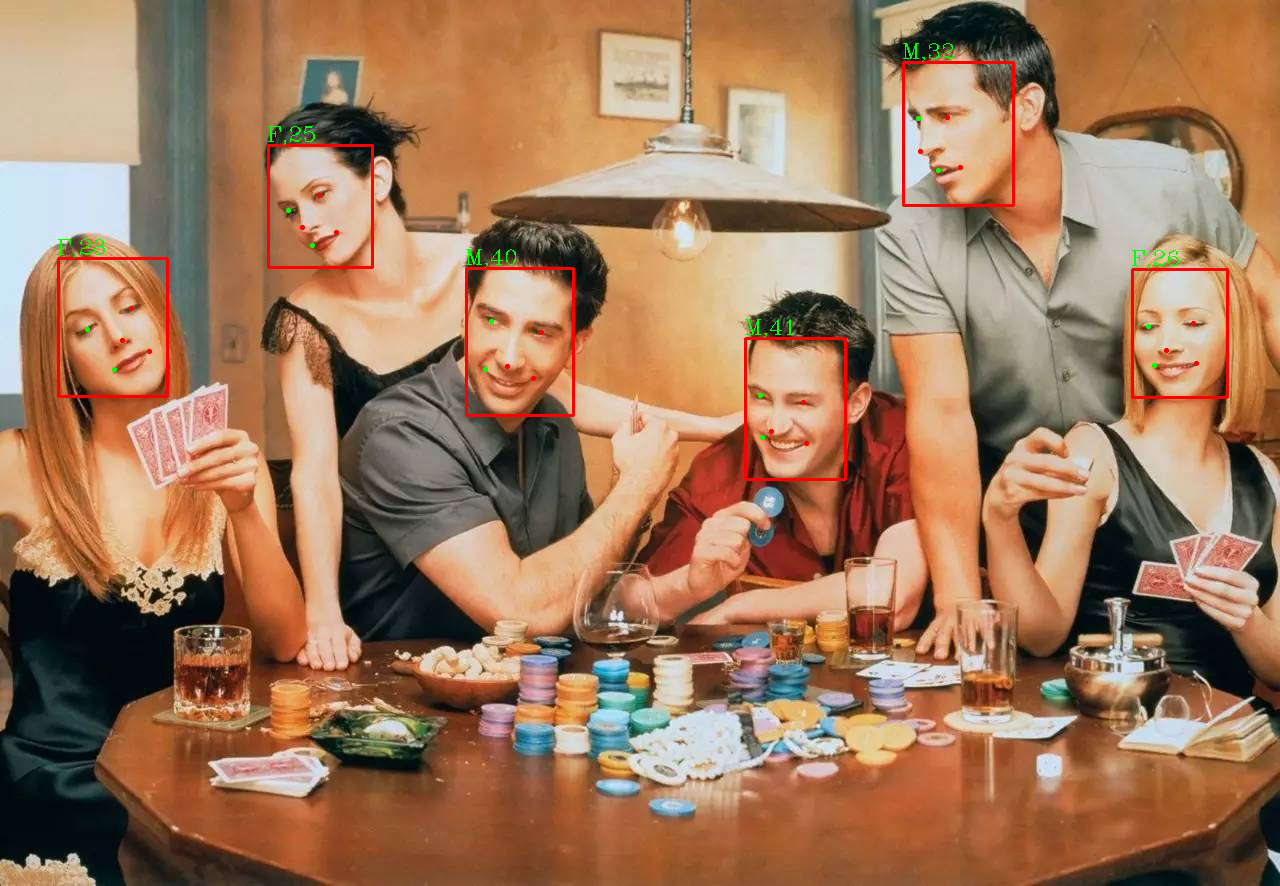

In [ ]:
from __future__ import division

import glob
import os.path as osp

import numpy as np
import onnxruntime
from numpy.linalg import norm

from insightface.model_zoo import model_zoo
from insightface.utils import DEFAULT_MP_NAME, ensure_available
from insightface.app.common import Face

__all__ = ['FaceAnalysis']

class FaceAnalysis:
    def __init__(self, name=DEFAULT_MP_NAME, root='~/.insightface', allowed_modules=None, **kwargs):
        onnxruntime.set_default_logger_severity(3)
        self.models = {}
        self.model_dir = ensure_available('models', name, root=root)
        onnx_files = glob.glob(osp.join(self.model_dir, '*.onnx'))
        onnx_files = sorted(onnx_files)
        for onnx_file in onnx_files:
            model = model_zoo.get_model(onnx_file, **kwargs)
            if model is None:
                print('model not recognized:', onnx_file)
            elif allowed_modules is not None and model.taskname not in allowed_modules:
                print('model ignore:', onnx_file, model.taskname)
                del model
            elif model.taskname not in self.models and (allowed_modules is None or model.taskname in allowed_modules):
                print('find model:', onnx_file, model.taskname, model.input_shape, model.input_mean, model.input_std)
                self.models[model.taskname] = model
            else:
                print('duplicated model task type, ignore:', onnx_file, model.taskname)
                del model
        assert 'detection' in self.models
        self.det_model = self.models['detection']

    def prepare(self, ctx_id, det_thresh=0.5, det_size=(640, 640)):
        self.det_thresh = det_thresh
        assert det_size is not None
        print('set det-size:', det_size)
        self.det_size = det_size
        for taskname, model in self.models.items():
            if (taskname == 'detection'):
                model.prepare(ctx_id, input_size=det_size, det_thresh=det_thresh)
            else:
                model.prepare(ctx_id)

    def get(self, img, max_num=0):
        bboxes, kpss = self.det_model.detect(img,
                                             max_num=max_num,
                                             metric='default')
        if bboxes.shape[0] == 0:
            return []
        ret = []
        for i in range(bboxes.shape[0]):
            bbox = bboxes[i, 0:4]
            det_score = bboxes[i, 4]
            kps = None
            if kpss is not None:
                kps = kpss[i]
            face = Face(bbox=bbox, kps=kps, det_score=det_score)
            for taskname, model in self.models.items():
                if taskname == 'detection':
                    continue
                model.get(img, face)
            ret.append(face)
        return ret

    def draw_on(self, img, faces):
        import cv2
        dimg = img.copy()
        for i in range(len(faces)):
            face = faces[i]
            box = face.bbox.astype(int)
            color = (0, 0, 255)
            cv2.rectangle(dimg, (box[0], box[1]), (box[2], box[3]), color, 2)
            if face.kps is not None:
                kps = face.kps.astype(int)
                # print(landmark.shape)
                for l in range(kps.shape[0]):
                    color = (0, 0, 255)
                    if l == 0 or l == 3:
                        color = (0, 255, 0)
                    cv2.circle(dimg, (kps[l][0], kps[l][1]), 1, color,
                               2)
            if face.gender is not None and face.age is not None:
                cv2.putText(dimg, '%s,%d' % (face.sex, face.age), (box[0] - 1, box[1] - 4), cv2.FONT_HERSHEY_COMPLEX,
                            0.7, (0, 255, 0), 1)

            # for key, value in face.items():
            #    if key.startswith('landmark_3d'):
            #        print(key, value.shape)
            #        print(value[0:10,:])
            #        lmk = np.round(value).astype(int)
            #        for l in range(lmk.shape[0]):
            #            color = (255, 0, 0)
            #            cv2.circle(dimg, (lmk[l][0], lmk[l][1]), 1, color,
            #                       2)
        return dimg

import cv2
from google.colab.patches import cv2_imshow

# Initialize the FaceAnalysis object
face_analyzer = FaceAnalysis()

# Prepare the models
face_analyzer.prepare(ctx_id=0, det_thresh=0.5, det_size=(640, 640))

# Load an image
img = cv2.imread('t1.jpg')

# Detect and analyze faces in the image
faces = face_analyzer.get(img)

# Draw the results on the image
annotated_img = face_analyzer.draw_on(img, faces)

# Display the annotated image
cv2_imshow(annotated_img)


In [ ]:
import os, sys, datetime
import numpy as np
import os.path as osp
import albumentations as A
from insightface.app import ImageOnlyTransform
from insightface.app.face_analysis import FaceAnalysis
from insightface.utils import get_model_dir
from insightface.thirdparty import face3d
from insightface.data import get_image as ins_get_image
from insightface.utils import DEFAULT_MP_NAME
import cv2

class MaskRenderer:
    def __init__(self, name=DEFAULT_MP_NAME, root='~/.insightface', insfa=None):
        #if insfa is None, enter render_only mode
        self.mp_name = name
        self.root = root
        self.insfa = insfa
        model_dir = get_model_dir(name, root)
        bfm_file = osp.join(model_dir, 'BFM.mat')
        assert osp.exists(bfm_file), 'should contains BFM.mat in your model directory'
        self.bfm = face3d.morphable_model.MorphabelModel(bfm_file)
        self.index_ind = self.bfm.kpt_ind
        bfm_uv_file = osp.join(model_dir, 'BFM_UV.mat')
        assert osp.exists(bfm_uv_file), 'should contains BFM_UV.mat in your model directory'
        uv_coords = face3d.morphable_model.load.load_uv_coords(bfm_uv_file)
        self.uv_size = (224,224)
        self.mask_stxr =  0.1
        self.mask_styr = 0.33
        self.mask_etxr = 0.9
        self.mask_etyr =  0.7
        self.tex_h , self.tex_w, self.tex_c = self.uv_size[1] , self.uv_size[0],3
        texcoord = np.zeros_like(uv_coords)
        texcoord[:, 0] = uv_coords[:, 0] * (self.tex_h - 1)
        texcoord[:, 1] = uv_coords[:, 1] * (self.tex_w - 1)
        texcoord[:, 1] = self.tex_w - texcoord[:, 1] - 1
        self.texcoord = np.hstack((texcoord, np.zeros((texcoord.shape[0], 1))))
        self.X_ind = self.bfm.kpt_ind
        self.mask_image_names = ['mask_white', 'mask_blue', 'mask_black', 'mask_green']
        self.mask_aug_probs = [0.4, 0.4, 0.1, 0.1]
        #self.mask_images = []
        #self.mask_images_rgb = []
        #for image_name in mask_image_names:
        #    mask_image = ins_get_image(image_name)
        #    self.mask_images.append(mask_image)
        #    mask_image_rgb = mask_image[:,:,::-1]
        #    self.mask_images_rgb.append(mask_image_rgb)


    def prepare(self, ctx_id=0, det_thresh=0.5, det_size=(128, 128)):
        self.pre_ctx_id = ctx_id
        self.pre_det_thresh = det_thresh
        self.pre_det_size = det_size

    def transform(self, shape3D, R):
        s = 1.0
        shape3D[:2, :] = shape3D[:2, :]
        shape3D = s * np.dot(R, shape3D)
        return shape3D

    def preprocess(self, vertices, w, h):
        R1 = face3d.mesh.transform.angle2matrix([0, 180, 180])
        t = np.array([-w // 2, -h // 2, 0])
        vertices = vertices.T
        vertices += t
        vertices = self.transform(vertices.T, R1).T
        return vertices

    def project_to_2d(self,vertices,s,angles,t):
        transformed_vertices = self.bfm.transform(vertices, s, angles, t)
        projected_vertices = transformed_vertices.copy() # using stantard camera & orth projection
        return projected_vertices[self.bfm.kpt_ind, :2]

    def params_to_vertices(self,params  , H , W):
        fitted_sp, fitted_ep, fitted_s, fitted_angles, fitted_t  = params
        fitted_vertices = self.bfm.generate_vertices(fitted_sp, fitted_ep)
        transformed_vertices = self.bfm.transform(fitted_vertices, fitted_s, fitted_angles,
                                                  fitted_t)
        transformed_vertices = self.preprocess(transformed_vertices.T, W, H)
        image_vertices = face3d.mesh.transform.to_image(transformed_vertices, H, W)
        return image_vertices

    def draw_lmk(self, face_image):
        faces = self.insfa.get(face_image, max_num=1)
        if len(faces)==0:
            return face_image
        return self.insfa.draw_on(face_image, faces)

    def build_params(self, face_image):
        #landmark = self.if3d68_handler.get(face_image)
        #if landmark is None:
        #    return None #face not found
        if self.insfa is None:
            self.insfa = FaceAnalysis(name=self.mp_name, root=self.root, allowed_modules=['detection', 'landmark_3d_68'])
            self.insfa.prepare(ctx_id=self.pre_ctx_id,  det_thresh=self.pre_det_thresh, det_size=self.pre_det_size)

        faces = self.insfa.get(face_image, max_num=1)
        if len(faces)==0:
            return None
        landmark = faces[0].landmark_3d_68[:,:2]
        fitted_sp, fitted_ep, fitted_s, fitted_angles, fitted_t = self.bfm.fit(landmark, self.X_ind, max_iter = 3)
        return [fitted_sp, fitted_ep, fitted_s, fitted_angles, fitted_t]

    def generate_mask_uv(self,mask, positions):
        uv_size = (self.uv_size[1], self.uv_size[0], 3)
        h, w, c = uv_size
        uv = np.zeros(shape=(self.uv_size[1],self.uv_size[0], 3), dtype=np.uint8)
        stxr, styr  = positions[0], positions[1]
        etxr, etyr = positions[2], positions[3]
        stx, sty = int(w * stxr), int(h * styr)
        etx, ety = int(w * etxr), int(h * etyr)
        height = ety - sty
        width = etx - stx
        mask = cv2.resize(mask, (width, height))
        uv[sty:ety, stx:etx] = mask
        return uv

    def render_mask(self,face_image, mask_image, params, input_is_rgb=False, auto_blend = True, positions=[0.1, 0.33, 0.9, 0.7]):
        if isinstance(mask_image, str):
            to_rgb = True if input_is_rgb else False
            mask_image = ins_get_image(mask_image, to_rgb=to_rgb)
        uv_mask_image = self.generate_mask_uv(mask_image, positions)
        h,w,c = face_image.shape
        image_vertices = self.params_to_vertices(params ,h,w)
        output = (1-face3d.mesh.render.render_texture(image_vertices, self.bfm.full_triangles , uv_mask_image, self.texcoord, self.bfm.full_triangles, h , w ))*255
        output = output.astype(np.uint8)
        if auto_blend:
            mask_bd = (output==255).astype(np.uint8)
            final = face_image*mask_bd + (1-mask_bd)*output
            return final
        return output

    #def mask_augmentation(self, face_image, label, input_is_rgb=False, p=0.1):
    #    if np.random.random()<p:
    #        assert isinstance(label, (list, np.ndarray)), 'make sure the rec dataset includes mask params'
    #        assert len(label)==237 or len(lable)==235, 'make sure the rec dataset includes mask params'
    #        if len(label)==237:
    #            if label[1]<0.0: #invalid label for mask aug
    #                return face_image
    #            label = label[2:]
    #        params = self.decode_params(label)
    #        mask_image_name = np.random.choice(self.mask_image_names, p=self.mask_aug_probs)
    #        pos = np.random.uniform(0.33, 0.5)
    #        face_image = self.render_mask(face_image, mask_image_name, params, input_is_rgb=input_is_rgb, positions=[0.1, pos, 0.9, 0.7])
    #    return face_image

    @staticmethod
    def encode_params(params):
        p0 = list(params[0])
        p1 = list(params[1])
        p2 = [float(params[2])]
        p3 = list(params[3])
        p4 = list(params[4])
        return p0+p1+p2+p3+p4

    @staticmethod
    def decode_params(params):
        p0 = params[0:199]
        p0 = np.array(p0, dtype=np.float32).reshape( (-1, 1))
        p1 = params[199:228]
        p1 = np.array(p1, dtype=np.float32).reshape( (-1, 1))
        p2 = params[228]
        p3 = tuple(params[229:232])
        p4 = params[232:235]
        p4 = np.array(p4, dtype=np.float32).reshape( (-1, 1))
        return p0, p1, p2, p3, p4

class MaskAugmentation(ImageOnlyTransform):

    def __init__(
            self,
            mask_names=['mask_white', 'mask_blue', 'mask_black', 'mask_green'],
            mask_probs=[0.4,0.4,0.1,0.1],
            h_low = 0.33,
            h_high = 0.35,
            always_apply=False,
            p=1.0,
            ):
        super(MaskAugmentation, self).__init__(always_apply, p)
        self.renderer = MaskRenderer()
        assert len(mask_names)>0
        assert len(mask_names)==len(mask_probs)
        self.mask_names = mask_names
        self.mask_probs = mask_probs
        self.h_low = h_low
        self.h_high = h_high
        #self.hlabel = None


    def apply(self, image, hlabel, mask_name, h_pos, **params):
        #print(params.keys())
        #hlabel = params.get('hlabel')
        assert len(hlabel)==237 or len(hlabel)==235, 'make sure the rec dataset includes mask params'
        if len(hlabel)==237:
            if hlabel[1]<0.0:
                return image
            hlabel = hlabel[2:]
        #print(len(hlabel))
        mask_params = self.renderer.decode_params(hlabel)
        image = self.renderer.render_mask(image, mask_name, mask_params, input_is_rgb=True, positions=[0.1, h_pos, 0.9, 0.7])
        return image

    @property
    def targets_as_params(self):
        return ["image", "hlabel"]

    def get_params_dependent_on_targets(self, params):
        hlabel = params['hlabel']
        mask_name = np.random.choice(self.mask_names, p=self.mask_probs)
        h_pos = np.random.uniform(self.h_low, self.h_high)
        return {'hlabel': hlabel, 'mask_name': mask_name, 'h_pos': h_pos}

    def get_transform_init_args_names(self):
        #return ("hlabel", 'mask_names', 'mask_probs', 'h_low', 'h_high')
        return ('mask_names', 'mask_probs', 'h_low', 'h_high')


if __name__ == "__main__":
    tool = MaskRenderer('antelope')
    tool.prepare(det_size=(128,128))
    image = cv2.imread("Tom_Hanks_54745.png")
    params = tool.build_params(image)
    #out = tool.draw_lmk(image)
    #cv2.imwrite('output_lmk.jpg', out)
    #mask_image  = cv2.imread("masks/mask1.jpg")
    #mask_image  = cv2.imread("masks/black-mask.png")
    #mask_image  = cv2.imread("masks/mask2.jpg")
    mask_out = tool.render_mask(image, 'mask_blue', params)# use single thread to test the time cost

    cv2.imwrite('output_mask.jpg', mask_out)



In [ ]:
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [ ]:
import os
import argparse
import cv2
import numpy as np
import sklearn
from sklearn.preprocessing import normalize
from easydict import EasyDict as edict
from insightface.app import FaceAnalysis

image_shape = [3, 112, 112]
net = None
emb_size = 0
use_flip = True

def do_flip(data):
    for idx in range(data.shape[0]):
        data[idx, :, :] = np.fliplr(data[idx, :, :])

def get_feature(buffer, app):
    global emb_size
    embeddings = []
    for item in buffer:
        img = cv2.imread(item)
        faces = app.get(img)
        for face in faces:
            embedding = face.embedding
            if emb_size == 0:
                emb_size = embedding.shape[0]
                print('set emb_size to ', emb_size)
            embeddings.append(embedding)
    embeddings = np.array(embeddings)
    if use_flip:
        embeddings = embeddings + embeddings  # Placeholder for actual flipping logic
    embeddings = sklearn.preprocessing.normalize(embeddings)
    return embeddings

def write_txt(path, m):
    np.savetxt(path, m, delimiter=',')

def main(args):
    global net

    print(args)
    app = FaceAnalysis(name=args.model_pack_name)
    app.prepare(ctx_id=0 if mx.context.num_gpus() else -1)

    buffer = [args.input]
    embedding = get_feature(buffer, app)
    write_txt(args.output, embedding)

def parse_arguments(argv):
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, help='', default=1)
    parser.add_argument('--image_size', type=str, help='', default='3,112,112')
    parser.add_argument('--input', type=str, help='', default='')
    parser.add_argument('--output', type=str, help='', default='')
    parser.add_argument('--model_pack_name', type=str, help='', default='buffalo_l')
    return parser.parse_args(argv)

if __name__ == '__main__':
    # Example arguments for Colab
    args = parse_arguments([
        '--batch_size', '1',
        '--image_size', '3,112,112',
        '--input', 't1.jpg',  # Adjust according to your uploaded image
        '--output', '/content/output2.txt',
        '--model_pack_name', 'buffalo_l'
    ])
    main(args)


Namespace(batch_size=1, image_size='3,112,112', input='t1.jpg', output='/content/output2.txt', model_pack_name='buffalo_l')


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


set emb_size to  512


In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

def read_embedding_from_file(file_path):
    with open(file_path, 'r') as f:
        content = f.read().strip()
        embeddings = np.array([list(map(float, line.split(','))) for line in content.split('\n')])
    return embeddings

def main():
    file_path1 = 'r1.txt'
    file_path2 = 'r2.txt'

    embeddings1 = read_embedding_from_file(file_path1)
    embeddings2 = read_embedding_from_file(file_path2)


    similarity = cosine_similarity(embeddings1, embeddings2)

    threshold = 0.9

    if similarity > threshold:
        print("Both output.txt files likely contain features of Ronaldo.")
    else:
        print("Features in output.txt files may not match.")

if __name__ == "__main__":
    main()


NameError: name 'similarity' is not defined

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to read embeddings from file
def read_embedding(file_path):
    with open(file_path, 'r') as f:
        line = f.readline().strip()
        embedding = np.array([float(x) for x in line.split(',')])
    return embedding

file_path1 = 'r1.txt'
file_path2 = 'output.txt'

embedding1 = read_embedding(file_path1)
embedding2 = read_embedding(file_path2)


embedding1 = embedding1.reshape(1, -1)
embedding2 = embedding2.reshape(1, -1)
embedding1 = embedding1 / np.linalg.norm(embedding1)
embedding2 = embedding2 / np.linalg.norm(embedding2)

similarity = cosine_similarity(embedding1, embedding2)

print(f"Cosine Similarity between embeddings in {file_path1} and {file_path2}: {similarity[0][0]}")


Cosine Similarity between embeddings in r1.txt and r2.txt: 0.7222522111898522
